In [1]:
# Env Blackjack
import gym
from gym import spaces
from gym.utils import seeding

import matplotlib.pyplot as plt

from matplotlib import cm

import numpy as np


def cmp(a, b):
    return float(a > b) - float(a < b)


# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21
    #return 0


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackEnv(gym.Env):
    """Simple blackjack environment
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over. They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with dealer having one face up and one face down card, while
    player having two face up cards. (Virtually for all Blackjack games today).
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    The observation of a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto.
    http://incompleteideas.net/book/the-book-2nd.html
    """
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()

    # Define reset position function to start from an initial position

    # def reset_init(self, hand_player, hand_dealer):
    #TODO


In [47]:
# Define the BlackJack env
env = BlackjackEnv(gym.Env)

# Play with it
obs = env.reset()

In [30]:
obs

(10, 5, False)

In [31]:
env.step(1)

((20, 5, False), 0.0, False, {})

In [32]:
env.step(0)

((20, 5, False), 0.0, True, {})

In [33]:
env.dealer

[5, 5, 10]

# Monte Carlo (MC) : Dealer vs. Random policy
PREFERABLE TO NOT USE ACE !!!!!

## In this part we will do MC prediction using dealer policy and compare it to the random one.

### For random policy let's compute the value function for each state using Monte Carlo formula

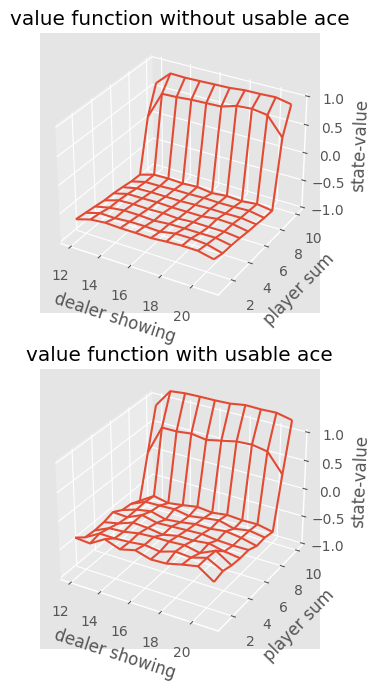

In [48]:
import numpy
import gym
from matplotlib import pyplot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict
from functools import partial
%matplotlib inline

plt.style.use('ggplot')

## Blackjack Environment

env.action_space, env.observation_space

def sample_policy(observation):
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

def generate_episode(policy, env):
    states, actions, rewards = [], [], []
    observation = env.reset()
    while True:
        states.append(observation)
        action = sample_policy(observation)
        actions.append(action)
        observation, reward, done, info = env.step(action)
        rewards.append(reward)
        if done:
            break

    return states, actions, rewards


def first_visit_mc_prediction(policy, env, n_episodes):
    value_table = defaultdict(float)
    N = defaultdict(int)

    for _ in range(n_episodes):
        states, _, rewards = generate_episode(policy, env)
        returns = 0
        for t in range(len(states) - 1, -1, -1):
            R = rewards[t]
            S = states[t]
            returns += R
            if S not in states[:t]:
                N[S] += 1
                value_table[S] += (returns - value_table[S]) / N[S]
    return value_table

def plot_blackjack(V, ax1, ax2):
    player_sum = numpy.arange(12, 21 + 1)
    dealer_show = numpy.arange(1, 10 + 1)
    usable_ace = numpy.array([False, True])

    state_values = numpy.zeros((len(player_sum),
                                len(dealer_show),
                                len(usable_ace)))

    for i, player in enumerate(player_sum):
        for j, dealer in enumerate(dealer_show):
            for k, ace in enumerate(usable_ace):
                state_values[i, j, k] = V[player, dealer, ace]

    X, Y = numpy.meshgrid(player_sum, dealer_show)

    ax1.plot_wireframe(X, Y, state_values[:, :, 0])
    ax2.plot_wireframe(X, Y, state_values[:, :, 1])
    for ax in ax1, ax2:
        ax.set_zlim(-1, 1)
        ax.set_ylabel('player sum')
        ax.set_xlabel('dealer showing')
        ax.set_zlabel('state-value')

fig, axes = pyplot.subplots(nrows=2, figsize=(5, 8), subplot_kw={'projection': '3d'})
axes[0].set_title('value function without usable ace')
axes[1].set_title('value function with usable ace')

value = first_visit_mc_prediction(sample_policy, env, n_episodes=500000)

plot_blackjack(value, axes[0], axes[1])

In [49]:
value

defaultdict(float,
            {(17, 4, False): -0.689351331083616,
             (15, 10, False): -0.6528216704288925,
             (14, 10, False): -0.6334857906367233,
             (13, 10, False): -0.6219779046805786,
             (20, 10, False): 0.43490648253670233,
             (16, 8, False): -0.6242517860590808,
             (11, 8, False): -0.06373008434864098,
             (18, 6, False): -0.6913914455874386,
             (16, 10, False): -0.6824044662623945,
             (16, 10, True): -0.37002703746620413,
             (13, 10, True): -0.2998413537810679,
             (12, 9, False): -0.5131103074141041,
             (11, 9, False): -0.0438212094653814,
             (13, 3, False): -0.5944201540703729,
             (20, 2, False): 0.6404584221748384,
             (10, 2, False): -0.11418880723572629,
             (19, 8, False): -0.7313296903460839,
             (19, 9, False): -0.7009544008483556,
             (19, 7, False): -0.71581041968162,
             (18, 7, False)

In [34]:
import sys
from collections import defaultdict

def mc_prediction(policy, env, num_episodes, discount_factor=1.0):

    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)

    # The final value function
    V = defaultdict(float)

    for i_episode in range(1, num_episodes + 1):
        # Print out which episode we're on, useful for debugging.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
        for t in range(100):
            action = policy(state)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # Find all states the we've visited in this episode
        # We convert each state to a tuple so that we can use it as a dict key
        states_in_episode = set([tuple(x[0]) for x in episode])
        for state in states_in_episode:
            # Find the first occurance of the state in the episode
            first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == state)
            # Sum up all rewards since the first occurance
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            # Calculate average return for this state over all sampled episodes
            returns_sum[state] += G
            returns_count[state] += 1.0
            V[state] = returns_sum[state] / returns_count[state]

    return V

In [35]:
def sample_policy(observation):
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

In [38]:
V_10k = mc_prediction(sample_policy, env, 10000)

Episode 10000/10000.

In [39]:
V_10k

defaultdict(float,
            {(19, 1, False): -0.8977272727272727,
             (19, 10, False): -0.7180616740088106,
             (21, 10, True): 1.223756906077348,
             (13, 4, False): -0.5564516129032258,
             (17, 4, False): -0.5495495495495496,
             (12, 4, False): -0.5979381443298969,
             (19, 6, False): -0.792,
             (9, 6, False): -0.75,
             (16, 9, False): -0.7019230769230769,
             (18, 9, False): -0.6140350877192983,
             (18, 8, False): -0.75,
             (8, 8, False): -0.52,
             (15, 10, False): -0.6074270557029178,
             (15, 5, False): -0.6122448979591837,
             (13, 5, False): -0.5794392523364486,
             (14, 10, False): -0.6498740554156172,
             (17, 10, False): -0.7367149758454107,
             (20, 9, False): 0.8383233532934131,
             (12, 9, False): -0.4606741573033708,
             (17, 3, False): -0.7398373983739838,
             (21, 3, False): 0.918918

In [40]:
# Initialize value function 
player_states_size = defaultdict(float)
dealer_states_size = defaultdict(float)
value_func_mc_random = defaultdict(float)

In [41]:
player_states_size

defaultdict(float, {})

In [ ]:
def mc_prediction(policy, env, num_episodes, discount_factor=1.0):

    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)

    # The final value function
    V = defaultdict(float)

    for i_episode in range(1, num_episodes + 1):
        # Print out which episode we're on, useful for debugging.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        state = env.reset()
        for t in range(100):
            action = policy(state)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # Find all states the we've visited in this episode
        # We convert each state to a tuple so that we can use it as a dict key
        states_in_episode = set([tuple(x[0]) for x in episode])
        for state in states_in_episode:
            # Find the first occurance of the state in the episode
            first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == state)
            # Sum up all rewards since the first occurance
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            # Calculate average return for this state over all sampled episodes
            returns_sum[state] += G
            returns_count[state] += 1.0
            V[state] = returns_sum[state] / returns_count[state]

    return V

In [ ]:
# For each state run 1000 iterations with random policy and compute the mean reward
# !!!!!! You should modify the BlackJackEnv to start from a particular state

nb_iteration = 10000

# Iteration over all possible states


In [ ]:
# To plot in 3D we have to create X and Y matrix
X = np.zeros((dealer_states_size, player_states_size))
Y = np.zeros((dealer_states_size, player_states_size))

for i in range(dealer_states_size):
  X[i,:] = i+1

for j in range(player_states_size):
  Y[:,j] = j+2

fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_surface(X, Y, value_func_mc_random, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

### For dealer policy let's compute the value function for each state using Monte Carlo formula

In [ ]:
# Initialize value function 
value_func_mc_dealer = 

In [ ]:
# For each state run 1000 iterations with dealer policy and compute the mean reward
# !!!!!! You should modify the BlackJackEnv to start from a particular state

nb_iteration = 10000




In [ ]:
# Plot the surface for dealer policy
surf = ax.plot_surface(X, Y, value_func_mc_dealer, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

In [ ]:
# Compare both 
value_diff = value_func_mc_dealer - value_func_mc_random

In [ ]:
# Plot the surface difference
surf = ax.plot_surface(X, Y, value_diff, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

In [ ]:
# To check only when random policy is better than dealer policy
value_diff_zero = np.zeros((dealer_states_size,player_states_size))
for i in range(dealer_states_size):
  for j in range(player_states_size):
    value_diff_zero[i,j] = min(0,value_diff[i,j])

In [ ]:
# Plot the surface for value_diff_zero.
surf = ax.plot_surface(X, Y, value_diff_zero, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Temporal Difference (TD) : Dealer vs. Random policy
PREFERABLE TO NOT USE ACE !!!!!

## In this part we will do TD prediction using dealer policy and compare it to the random one.

### For random policy let's compute the value function for each state using TD formula

In [ ]:
# Parameters for TD
alpha = 1
gamma = 0.9

In [ ]:
# Initialize action value function 
# HERE YOU MUST TAKE INTO ACCOUNT THE DEALER HAND
value_func_td_random = #TODO

In [ ]:
# Play only one step and update TD


# Start from one random position
env.reset()

# Take one random action


# Update for one step your value_func_td_random matrix according to the formula Main formula of TD(1)
# V(St) <- V(St ) +  α(Rt+1+ γV(St+1) - V(St))


# Update value_func_td_random


(14, 7, False)

In [ ]:
# Copy paste you code for one step and play ONE GAME (ie until the end of the episod)

env.reset()
done = False
# We play util finish the game
while (not done):
  # TODO
  


In [ ]:
# Copy paste you code ONE GAME and do i for 1000000 iterations

for i in range(1000000):
  env.reset()
  done = False
  # We play util finish the game
  while (not done):
    # TODO
  

In [ ]:
# Plot the surface.

### For dealer policy let's compute the value function for each state using TD formula

In [ ]:
# Initialize value function 
value_func_td_dealer = #TODO

In [ ]:
# Play about 1000000 games with random policy and compute value function for TD


In [ ]:
# Plot and compare function

## SARSA and Q-learning

### Let's implement epsilon-greedy policy function

In [ ]:

# Suppose you are at state S, with action_value_function Q : action_value_func_td_eps_greedy
# Define epsilon-greedy function

def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: The matrix of action value function
            Q[dealer_hand, player_hand, action]
        
        epsilon: The probability to select a random action . float between 0 and 1.
    
    Returns:
        Action 0 or 1
        
    """

    return action

### Apply SARSA to the game

In [ ]:
# Initialize action value function
# TODO
action_value_func_SARSA_eps_greedy = #TODO


In [ ]:
# Play only one step and update action value function for SARSA


# Start from one random position
env.reset()

# For state (St) Take one eps greedy action (At)

# For state (St+1) Take a second eps greedy action (At+1)


# Update for one step your value_func_td_random matrix according to the formula Main formula of TD(1)
# Q(St,At) <- Q(St,At) +  α(Rt+1+ γQ(St+1,At+1) - Q(St,At))




In [ ]:
# Copy paste you code for one step and play ONE GAME (ie until the end of the episod)

env.reset()
done = False
# We play util finish the game
while (not done):
  # TODO

In [ ]:
# Copy paste you code ONE GAME and do i for 1000000 iterations

for i in range(1000000):
  env.reset()
  done = False
  # We play util finish the game
  while (not done):
    # TODO
  

### Apply Q-learning

In [ ]:
# TODO Off policy over on-policy SARSA

In [ ]:
# Compare learning time of SARSA vs. Qlearning (ie draw ecart over iteration and see first to converge)